In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from prince import FAMD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import precision_recall_curve


In [3]:
def encoder(df, col_split):
    """
    Prepares the data for the model by standardizing the continuous features, 
    converting the categorical features to strings, 
    and converting sparse columns to a dense format for FAMD.
    """
    categorical_cols = df.columns[:col_split]
    # converting the categorical features to strings
    df[categorical_cols] = df[categorical_cols].astype(str)
    return df

def load_data(data_address='beta_dates/beta_data_2_42.csv', label_address='beta_dates/true_labels.csv'):
    df = pd.read_csv(data_address, index_col=0)
    y = pd.read_csv(label_address, index_col=0).values[:,0]
    y = y + 1
    X = encoder(df, 4)
    return X, y

In [44]:
# Load your data
X, y = load_data()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Parameters for Random Forest
params = {
    'rf__max_depth': 4,
    'rf__max_features': 0.65,
    'rf__min_samples_leaf': 6,
    'rf__min_samples_split': 17,
    'rf__n_estimators': 200
}

# Create the pipeline with FAMD and RandomForestClassifier
pipe = Pipeline([
    ('famd', FAMD(n_components=6)),  # FAMD with 6 components
    ('rf', RandomForestClassifier()) # Random Forest Classifier
])

# Set the parameters for the pipeline
pipe.set_params(**params)

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Evaluate the model on the test data
test_accuracy = pipe.score(X_test, y_test)
print('Test Accuracy:', test_accuracy)

# Print the classification report on the test data
print(classification_report(y_test, pipe.predict(X_test)))

# Save the model
joblib.dump(pipe, 'random_forest_famd_model.pkl')
# Load your data
X, y = load_data()

# Apply FAMD for dimensionality reduction
famd = FAMD(n_components=6)
famd.fit(X)
X_transformed = famd.transform(X)

# Create a pipeline with the best parameters
pipe = Pipeline([
    ('xgb', XGBClassifier(objective='multi:softmax'))  # Example for a classification task
])

# Set the parameters for the pipeline
params = {
    'xgb__colsample_bytree': 0.8314087089720534, 
    'xgb__gamma': 2.068218435894297, 
    'xgb__learning_rate': 0.7757676744286774, 
    'xgb__max_depth': 4, 
    'xgb__min_child_weight': 5.920879982985454, 
    'xgb__n_estimators': 156, 
    'xgb__reg_alpha': 2.0124120042376505, 
    'xgb__reg_lambda': 4.703662676675085, 
    'xgb__subsample': 0.7918852620425526
}
pipe.set_params(**params)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2)

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Make predictions on the test set
predictions = pipe.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy:', accuracy)

# Print the classification report
print(classification_report(y_test, predictions))

# Save the model
joblib.dump(pipe, 'random_forest_famd_model.pkl')

Test Accuracy: 0.7636363636363637
              precision    recall  f1-score   support

         0.0       0.67      0.40      0.50         5
         1.0       0.79      0.95      0.86        39
         2.0       0.60      0.27      0.37        11

    accuracy                           0.76        55
   macro avg       0.68      0.54      0.58        55
weighted avg       0.74      0.76      0.73        55

Test Accuracy: 0.7636363636363637
              precision    recall  f1-score   support

         0.0       0.67      0.40      0.50         5
         1.0       0.83      0.85      0.84        40
         2.0       0.55      0.60      0.57        10

    accuracy                           0.76        55
   macro avg       0.68      0.62      0.64        55
weighted avg       0.76      0.76      0.76        55



['random_forest_famd_model.pkl']

In [33]:
# Load your data
X, y = load_data()

famd = FAMD(n_components=6)
famd.fit(X)
X_transformed = famd.transform(X)


# Define the pipeline
pipe = Pipeline([
    ('rf', RandomForestClassifier()),
])

# Set pipeline parameters
params = {'rf__max_depth': 4, 'rf__max_features': 0.65, 'rf__min_samples_leaf': 6, 'rf__min_samples_split': 17, 'rf__n_estimators': 200}
pipe.set_params(**params)

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True)

# List to store accuracy scores for this iteration
accuracy_scores = []

# Perform K-Fold Cross-Validation
for train_index, test_index in skf.split(X_transformed, y):
    X_train, X_test = X_transformed.iloc[train_index], X_transformed.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline and make predictions
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)

    # Calculate and store accuracy
    accuracy_scores.append(accuracy_score(y_test, predictions))

# Calculate average accuracy for this iteration
avg_accuracy = np.mean(accuracy_scores)

# Print the accuracy scores
print('Accuracy Scores: {} \n'.format(accuracy_scores))
print('Average Accuracy: {}'.format(avg_accuracy))


Accuracy Scores: [0.8181818181818182, 0.7818181818181819, 0.8181818181818182, 0.7454545454545455, 0.8148148148148148] 

Average Accuracy: 0.7956902356902358


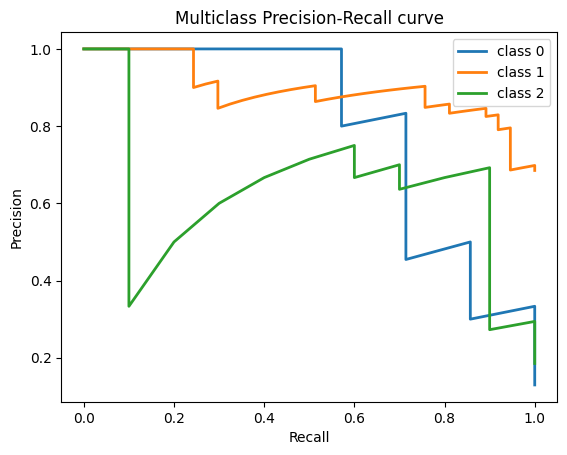

In [34]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Assuming y has 3 classes: 0, 1, 2

# Getting scores for each class
y_scores = pipe.predict_proba(X_test)
y_bin = label_binarize(y_test, classes=[0, 1, 2])


# Plotting Precision-Recall curve for each class
for i in range(3):  
    precision, recall, _ = precision_recall_curve(y_bin[:, i], y_scores[:, i])
    plt.plot(recall, precision, lw=2, label=f'class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="best")
plt.title('Multiclass Precision-Recall curve')
plt.show()


In [68]:
X, y = load_data()
y_guesses = np.ones(len(y))
for i in range(1, len(y)):
    y_guesses[i] = y[i-1]

print(accuracy_score(y, y_guesses))
famd = FAMD(n_components=6)
famd.fit(X)
X_transformed = famd.transform(X)
# print(pipe.predict(X_transformed))
# print(y_guesses)
for pipe in model_list:
    diff = y_guesses != pipe.predict(X_transformed)
    # print(pipe.predict(X_transformed)[diff])
    # print(y[diff])
    # print(y_guesses[diff])

    print(accuracy_score(pipe.predict(X_transformed)[diff], y[diff]))
    # print(accuracy_score(y_guesses[diff], y[diff]))

0.7262773722627737
0.8
0.8
0.8
0.8
0.8


In [11]:
# Load your data
X, y = load_data()

famd = FAMD(n_components=6)
famd.fit(X)
X = famd.transform(X)


# create a pipeline with the best parameters
pipe = Pipeline([
    ('xgb', XGBClassifier(objective='multi:softmax'))  # Example for a classification task
])

# Perform K-Fold Cross-Validation

# set the parameters to the mean values
params = {
    'xgb__colsample_bytree': 0.8314087089720534, 
    'xgb__gamma': 2.068218435894297, 
    'xgb__learning_rate': 0.7757676744286774, 
    'xgb__max_depth': 4, 
    'xgb__min_child_weight': 5.920879982985454, 
    'xgb__n_estimators': 156, 
    'xgb__reg_alpha': 2.0124120042376505, 
    'xgb__reg_lambda': 4.703662676675085, 
    'xgb__subsample': 0.7918852620425526}

pipe.set_params(**params)
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True)

# List to store accuracy scores for this iteration
accuracy_scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipe.predict(X_test)

    accuracy_scores.append(accuracy_score(y_test, predictions))

# Calculate average accuracy for this iteration
avg_accuracy = np.mean(accuracy_scores)

# Print the accuracy scores
print('Accuracy Scores: {} \n'.format(accuracy_scores))
print('Average Accuracy: {}'.format(avg_accuracy))


Accuracy Scores: [0.7090909090909091, 0.7272727272727273, 0.8, 0.8181818181818182, 0.8148148148148148] 

Average Accuracy: 0.7738720538720539


In [1]:
# Load your data
X, y = load_data()

# Parameters for both Random Forest and XGBClassifier
rf_params = {
    'rf__max_depth': 4,
    'rf__max_features': 0.65,
    'rf__min_samples_leaf': 6,
    'rf__min_samples_split': 17,
    'rf__n_estimators': 200
}

xgb_params = {
    'xgb__colsample_bytree': 0.8314087089720534, 
    'xgb__gamma': 2.068218435894297, 
    'xgb__learning_rate': 0.7757676744286774, 
    'xgb__max_depth': 4, 
    'xgb__min_child_weight': 5.920879982985454, 
    'xgb__n_estimators': 156, 
    'xgb__reg_alpha': 2.0124120042376505, 
    'xgb__reg_lambda': 4.703662676675085, 
    'xgb__subsample': 0.7918852620425526
}

# Number of iterations
iterations = 30

# Initialize lists to store accuracies for each model
rf_accuracies = []
xgb_accuracies = []

for _ in range(iterations):
    # Split the data for Random Forest pipeline
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    split_index = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Create and fit the Random Forest pipeline
    rf_pipe = Pipeline([
        ('famd', FAMD(n_components=6)),
        ('rf', RandomForestClassifier())
    ])
    rf_pipe.set_params(**rf_params)
    rf_pipe.fit(X_train, y_train)

    # Evaluate the Random Forest model
    rf_accuracies.append(rf_pipe.score(X_test, y_test))

    # Apply FAMD and create the XGBClassifier pipeline
    famd = FAMD(n_components=6)
    famd.fit(X_train)
    X_xgb_train_transformed = famd.transform(X_train)
    X_xgb_test_transformed = famd.transform(X_test)

    xgb_pipe = Pipeline([
        ('xgb', XGBClassifier(objective='multi:softmax'))
    ])
    xgb_pipe.set_params(**xgb_params)
    xgb_pipe.fit(X_xgb_train_transformed, y_train)

    # Evaluate the XGBClassifier model
    xgb_accuracies.append(xgb_pipe.score(X_xgb_test_transformed, y_test))

# Calculate the average accuracy for each model
avg_rf_accuracy = np.mean(rf_accuracies)
avg_xgb_accuracy = np.mean(xgb_accuracies)

# Print the average accuracies
print('Average RF Accuracy:', avg_rf_accuracy)
print('Average XGB Accuracy:', avg_xgb_accuracy)

NameError: name 'load_data' is not defined

In [24]:
# Load your data
X, y = load_data()

# Parameters for Random Forest
rf_params = {
    'rf__max_depth': 4,
    'rf__max_features': 0.65,
    'rf__min_samples_leaf': 6,
    'rf__min_samples_split': 17,
    'rf__n_estimators': 200
}

# Parameters for XGBClassifier
xgb_params = {
    'xgb__colsample_bytree': 1.0, 
    'xgb__gamma': 3.646092407548312, 
    'xgb__learning_rate': 0.01, 
    'xgb__max_depth': 6, 
    'xgb__min_child_weight': 9.488817186497869, 
    'xgb__n_estimators': 81, 
    'xgb__reg_alpha': 1.5988455864986395, 
    'xgb__reg_lambda': 3.267653422896763, 
    'xgb__subsample': 1.0}

# split the rf_params and xgb_params on __, and get the split and final index
rf_param_names = {param.split('__')[1]:rf_params[param] for param in rf_params.keys()}
xgb_param_names = {param.split('__')[1]:xgb_params[param] for param in xgb_params.keys()}
split_index, final_index = int(len(X) * 0.5), len(X)

# Initialize lists to store accuracies for each model
rf_accuracies = []
xgb_accuracies = []

# Repeat the experiment 20 times and initialize the prediction lists
iterations = 4
for j in range(iterations):
    rf_predictions = []
    xgb_predictions = []
    y_actual = []
    
    # Iterate through the data and get the train test split based on the split day
    for i in range(split_index, final_index):
        # Get the FAMD transformation
        X_current = X.iloc[:i+1]
        famd = FAMD(n_components=6, engine='sklearn')
        famd.fit(X_current)
        X_famd = famd.transform(X_current)

        # Get the train test split
        X_train, X_test = X_famd[:i], X_famd[i:i+1]
        y_train, y_test = y[:i], y[i:i+1]

        # Create and fit the Random Forest classifier, append the prediction to rf_guess
        rf_classifier = RandomForestClassifier(warm_start=False)
        rf_classifier.set_params(**rf_param_names)
        rf_classifier.fit(X_train, y_train)
        rf_predictions.append(rf_classifier.predict(X_test))

        # Create and fit the XGBClassifier, append the prediction to xgb_guess
        xgb_classifier = XGBClassifier()
        xgb_classifier.set_params(**xgb_param_names)
        xgb_classifier.fit(X_train, y_train)
        xgb_predictions.append(xgb_classifier.predict(X_test))

        # Append the actual value to y_actual
        y_actual.append(y_test)

    # Calculate the accuracy scores for each model
    rf_accuracy = accuracy_score(np.array(y_actual), np.array(rf_predictions))
    xgb_accuracy = accuracy_score(np.array(y_actual), np.array(xgb_predictions))
    rf_accuracies.append(rf_accuracy)
    xgb_accuracies.append(xgb_accuracy)

In [27]:
# print the mean accuracy scores for each model
print('Average RF Accuracy:', np.mean(rf_accuracies))
print('Average XGB Accuracy:', np.mean(xgb_accuracies))

Average RF Accuracy: 0.8094890510948906
Average XGB Accuracy: 0.7883211678832116
